# Group Ticket Visualization - Single Ticket Analysis

This notebook visualizes a **single group ticket** to help determine whether issues are:
- Model Stage-A mistakes
- Model reasoning errors
- Ground truth label noise

**Supports Two Modes:**
1. **With need_review_queue**: Full analysis including Stage-B model verdict and reasoning
2. **Without need_review_queue**: Basic visualization with images and Stage-A summaries only

**Workflow:**
1. Set `GROUP_ID` variable to the group_id you want to analyze
2. Display images grouped by submission directory (审核通过 vs 审核不通过)
3. Show available data:
   - **Always shown**: Images (if available)
   - **If stage_a.jsonl exists**: Stage-A summary (per_image summaries)
   - **If need_review_queue.jsonl exists**: Model verdict, reasoning, and comparison

**Note:** A group_id can have images in both `审核通过/` and `审核不通过/` directories (multiple submissions). These are treated separately and displayed in separate sections.

In [1]:
import json
import os
from pathlib import Path
from typing import List, Dict, Optional
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image as PILImage
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Configuration
REPO_ROOT = Path("/data/Qwen3-VL")
MISSION="挡风板安装检查"
RUN_NAME="12-18"
NEED_REVIEW_QUEUE_PATH = (
    REPO_ROOT / f"output_post/stage_b/{MISSION}/{RUN_NAME}/need_review_queue.jsonl"
)
STAGE_A_JSONL_PATH = REPO_ROOT / f"output_post/stage_a/{MISSION}_stage_a.jsonl"
GROUP_DATA_BASE = REPO_ROOT / f"group_data/bbu_scene_2.0_order/{MISSION}"

# Possible subdirectories where group_id folders might be located
POSSIBLE_SUBDIRS = ["审核通过", "审核不通过"]

# ============================================================================
# SET THIS VARIABLE TO THE GROUP_ID YOU WANT TO ANALYZE
# ============================================================================

GROUP_ID = "QC-20241204-0034880"  # Change this to your target group_id

In [3]:
def load_single_need_review_entry(jsonl_path: Path, group_id: str) -> Optional[Dict]:
    """Load a single entry from need_review_queue.jsonl by group_id"""
    if not jsonl_path.exists():
        print(f"Warning: {jsonl_path} does not exist")
        return None
    
    # Find the latest entry for this group_id (by epoch and reflection_cycle)
    matching_entries = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                entry = json.loads(line)
                if entry.get("group_id") == group_id:
                    matching_entries.append(entry)
    
    if not matching_entries:
        return None
    
    # Return the latest entry (highest epoch, then highest reflection_cycle)
    def sort_key(e):
        epoch = int(e.get("epoch", 0)) if str(e.get("epoch", "0")).isdigit() else 0
        cycle = int(e.get("reflection_cycle", 0)) if str(e.get("reflection_cycle", "0")).isdigit() else 0
        return (epoch, cycle)
    
    return max(matching_entries, key=sort_key)


def load_stage_a_entry(jsonl_path: Path, group_id: str) -> Optional[Dict]:
    """Load a single entry from stage_a.jsonl by group_id"""
    if not jsonl_path.exists():
        print(f"Warning: {jsonl_path} does not exist")
        return None
    
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                entry = json.loads(line)
                if entry.get("group_id") == group_id:
                    return entry
    
    return None

In [4]:
def find_group_images_by_subdir(
    group_id: str, base_path: Path, subdirs: List[str]
) -> Dict[str, List[Path]]:
    """Find all .jpeg images for a given group_id, grouped by subdirectory"""
    images_by_subdir = {}

    for subdir in subdirs:
        group_dir = base_path / subdir / group_id
        if group_dir.exists() and group_dir.is_dir():
            # Find all .jpeg files
            found_images = sorted(group_dir.glob("*.jpeg"))
            if found_images:
                images_by_subdir[subdir] = found_images
                print(f"Found {len(found_images)} images in {subdir}/{group_id}")

    return images_by_subdir

In [5]:
def display_images_by_subdir(images_by_subdir: Dict[str, List[Path]], group_id: str):
    """Display images grouped by subdirectory (审核通过 vs 审核不通过)"""
    if not images_by_subdir:
        print(f"⚠️  No images found for group_id: {group_id}")
        return

    for subdir, images in images_by_subdir.items():
        if not images:
            continue

        num_images = len(images)
        cols = min(3, num_images)
        rows = (num_images + cols - 1) // cols

        fig = plt.figure(figsize=(15, 5 * rows))
        gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3)

        for idx, img_path in enumerate(images):
            row = idx // cols
            col = idx % cols
            ax = fig.add_subplot(gs[row, col])

            try:
                img = PILImage.open(img_path)
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(f"Image {idx + 1}", fontsize=12, fontweight="bold")
            except Exception as e:
                ax.text(
                    0.5,
                    0.5,
                    f"Error loading image:\n{str(e)}",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                    fontsize=10,
                )
                ax.axis("off")

        subdir_color = "green" if subdir == "审核通过" else "red"
        plt.suptitle(
            f"Group ID: {group_id} - {subdir} ({len(images)} images)",
            fontsize=16,
            fontweight="bold",
            y=0.98,
            color=subdir_color,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()


def display_stage_a_only(group_id: str, stage_a_entry: Optional[Dict]):
    """Display Stage-A summary when need_review_entry is not available"""
    stage_a_label = stage_a_entry.get("label") if stage_a_entry else None
    stage_a_per_image = stage_a_entry.get("per_image", {}) if stage_a_entry else {}

    label_color = (
        "green"
        if stage_a_label == "pass"
        else ("red" if stage_a_label == "fail" else "gray")
    )

    comparison_html = f"""
    <div style="border: 2px solid #2196f3; padding: 20px; margin: 20px 0; background-color: #f9f9f9; border-radius: 8px;">
        <h2 style="margin-top: 0; color: #2196f3; border-bottom: 2px solid #2196f3; padding-bottom: 10px;">
            Group ID: {group_id} - Stage-A Analysis Only
        </h2>
        
        <div style="background-color: white; padding: 15px; border-radius: 5px; margin: 15px 0; border-left: 4px solid {label_color};">
            <h3 style="margin-top: 0; color: {label_color};">Stage-A Label</h3>
            <p style="font-size: 18px; font-weight: bold; color: {label_color};">
                {stage_a_label if stage_a_label else "N/A"}
            </p>
            <p style="font-size: 14px; color: #666; margin-top: 5px;">
                (from stage_a.jsonl)
            </p>
        </div>
        
        <div style="background-color: white; padding: 15px; border-radius: 5px; margin: 15px 0; border-left: 4px solid #9c27b0;">
            <h3 style="margin-top: 0; color: #9c27b0;">Stage-A Summary (Per Image)</h3>
    """

    if stage_a_per_image:
        for img_key, summary in sorted(stage_a_per_image.items()):
            comparison_html += f"""
            <div style="margin: 10px 0; padding: 10px; background-color: #f5f5f5; border-radius: 4px;">
                <strong style="color: #9c27b0;">{img_key}:</strong>
                <div style="margin-top: 5px; font-family: monospace; font-size: 13px; line-height: 1.5; white-space: pre-wrap;">
                    {summary}
                </div>
            </div>
            """
    else:
        comparison_html += '<p style="color: #999;">No Stage-A summary available</p>'

    comparison_html += """
        </div>
        
        <div style="margin-top: 15px; padding: 10px; background-color: #fff3e0; border-radius: 4px; font-size: 12px; color: #666;">
            <strong>Note:</strong> This group_id is not in need_review_queue.jsonl. Only Stage-A data is available.
        </div>
    </div>
    """

    display(HTML(comparison_html))


def display_comparison(
    need_review_entry: Optional[Dict],
    stage_a_entry: Optional[Dict],
    group_id: str = "Unknown",
):
    """Display comparison: Stage-A summary, model verdict/reason, and GT label comparison

    Works with or without need_review_entry. If need_review_entry is None, shows Stage-A only.
    If both are None, shows a message that no data is available.

    Args:
        need_review_entry: Optional entry from need_review_queue.jsonl
        stage_a_entry: Optional entry from stage_a.jsonl
        group_id: Group ID string (used for display when entries are None)
    """
    if need_review_entry is None:
        # Fall back to Stage-A only display
        if stage_a_entry is None:
            # No data available at all
            comparison_html = f"""
            <div style="border: 2px solid #ff9800; padding: 20px; margin: 20px 0; background-color: #fff3e0; border-radius: 8px;">
                <h2 style="margin-top: 0; color: #ff9800; border-bottom: 2px solid #ff9800; padding-bottom: 10px;">
                    No Data Available for Group ID: {group_id}
                </h2>
                <p style="color: #666; line-height: 1.6;">
                    This group_id was not found in either:
                    <ul>
                        <li>need_review_queue.jsonl (Stage-B data)</li>
                        <li>stage_a.jsonl (Stage-A data)</li>
                    </ul>
                    Only images (if available) will be displayed.
                </p>
            </div>
            """
            display(HTML(comparison_html))
            return

        # Get group_id from stage_a_entry if not provided
        display_group_id = (
            stage_a_entry.get("group_id", group_id) if stage_a_entry else group_id
        )
        display_stage_a_only(display_group_id, stage_a_entry)
        return

    # Use group_id from need_review_entry
    group_id = need_review_entry.get("group_id", group_id)
    gt_label = need_review_entry.get("gt_label", "Unknown")
    chosen_verdict = need_review_entry.get("chosen_verdict", "Unknown")
    reason = need_review_entry.get("reason", "")
    tag = need_review_entry.get("tag", "")
    epoch = need_review_entry.get("epoch", "")
    reflection_cycle = need_review_entry.get("reflection_cycle", "")
    evidence_summary = need_review_entry.get("evidence_summary", {})

    # Get stage_a data
    stage_a_label = stage_a_entry.get("label") if stage_a_entry else None
    stage_a_per_image = stage_a_entry.get("per_image", {}) if stage_a_entry else {}

    # Determine label match status
    label_match = gt_label == chosen_verdict
    match_status = "✓ MATCH" if label_match else "✗ MISMATCH"
    match_color = "green" if label_match else "red"

    # Create comparison HTML
    comparison_html = f"""
    <div style="border: 2px solid {match_color}; padding: 20px; margin: 20px 0; background-color: #f9f9f9; border-radius: 8px;">
        <h2 style="margin-top: 0; color: {match_color}; border-bottom: 2px solid {match_color}; padding-bottom: 10px;">
            {match_status} - Group ID: {group_id}
        </h2>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin: 15px 0;">
            <div style="background-color: white; padding: 15px; border-radius: 5px; border-left: 4px solid blue;">
                <h3 style="margin-top: 0; color: blue;">GT Label (Input to Stage-B)</h3>
                <p style="font-size: 18px; font-weight: bold; color: {"green" if gt_label == "pass" else "red"};">
                    {gt_label}
                </p>
                <p style="font-size: 14px; color: #666; margin-top: 5px;">
                    (from stage_a.jsonl label)
                </p>
            </div>
            
            <div style="background-color: white; padding: 15px; border-radius: 5px; border-left: 4px solid {"green" if chosen_verdict == "pass" else "red"};">
                <h3 style="margin-top: 0; color: {"green" if chosen_verdict == "pass" else "red"};">Model Verdict (Stage-B)</h3>
                <p style="font-size: 18px; font-weight: bold; color: {"green" if chosen_verdict == "pass" else "red"};">
                    {chosen_verdict}
                </p>
                <p style="font-size: 14px; color: #666; margin-top: 5px;">
                    Tag: <span style="color: orange; font-weight: bold;">{tag}</span>
                </p>
            </div>
        </div>
        
        <div style="background-color: white; padding: 15px; border-radius: 5px; margin: 15px 0; border-left: 4px solid #ff9800;">
            <h3 style="margin-top: 0; color: #ff9800;">Model Reasoning (Stage-B)</h3>
            <div style="background-color: #fafafa; padding: 12px; border-radius: 4px; font-family: monospace; white-space: pre-wrap; line-height: 1.6; max-height: 400px; overflow-y: auto;">
                {reason if reason else "(empty)"}
            </div>
        </div>
        
        <div style="background-color: white; padding: 15px; border-radius: 5px; margin: 15px 0; border-left: 4px solid #9c27b0;">
            <h3 style="margin-top: 0; color: #9c27b0;">Stage-A Summary (Per Image)</h3>
    """

    if stage_a_per_image:
        for img_key, summary in sorted(stage_a_per_image.items()):
            comparison_html += f"""
            <div style="margin: 10px 0; padding: 10px; background-color: #f5f5f5; border-radius: 4px;">
                <strong style="color: #9c27b0;">{img_key}:</strong>
                <div style="margin-top: 5px; font-family: monospace; font-size: 13px; line-height: 1.5; white-space: pre-wrap;">
                    {summary}
                </div>
            </div>
            """
    else:
        comparison_html += '<p style="color: #999;">No Stage-A summary available</p>'

    # Add evidence summary if available
    if evidence_summary:
        rel_neg = evidence_summary.get("relevant_negative_hits", [])
        pending = evidence_summary.get("pending_signal_hits", [])
        if rel_neg or pending:
            comparison_html += """
        </div>
        
        <div style="background-color: white; padding: 15px; border-radius: 5px; margin: 15px 0; border-left: 4px solid #607d8b;">
            <h3 style="margin-top: 0; color: #607d8b;">Evidence Summary</h3>
            """
            if rel_neg:
                comparison_html += '<div style="margin: 10px 0;"><strong>Relevant Negative Hits:</strong><ul>'
                for hit in rel_neg[:5]:  # Show first 5
                    comparison_html += f'<li style="font-size: 12px;">{hit}</li>'
                comparison_html += "</ul></div>"
            if pending:
                comparison_html += '<div style="margin: 10px 0;"><strong>Pending Signal Hits:</strong><ul>'
                for hit in pending[:5]:  # Show first 5
                    comparison_html += f'<li style="font-size: 12px;">{hit}</li>'
                comparison_html += "</ul></div>"
            comparison_html += "</div>"

    comparison_html += """
        </div>
        
        <div style="margin-top: 15px; padding: 10px; background-color: #e3f2fd; border-radius: 4px; font-size: 12px; color: #666;">
            <strong>Metadata:</strong> Epoch {epoch}, Reflection Cycle {reflection_cycle}
        </div>
    </div>
    """.format(epoch=epoch, reflection_cycle=reflection_cycle)

    display(HTML(comparison_html))

In [6]:
# ============================================================================
# STEP 1: Load all available data for GROUP_ID
# ============================================================================
print(f"Loading data for group_id: {GROUP_ID}")
print("=" * 80)

# Try to load need_review_entry (optional)
need_review_entry = load_single_need_review_entry(NEED_REVIEW_QUEUE_PATH, GROUP_ID)
if need_review_entry is None:
    print(f"ℹ️  Group ID '{GROUP_ID}' not found in need_review_queue.jsonl")
    print(f"   Path: {NEED_REVIEW_QUEUE_PATH}")
    print(f"   → Will show Stage-A data and images only")
else:
    print(f"✓ Found entry in need_review_queue.jsonl")
    print(f"  - GT Label: {need_review_entry.get('gt_label', 'N/A')}")
    print(f"  - Model Verdict: {need_review_entry.get('chosen_verdict', 'N/A')}")
    print(f"  - Tag: {need_review_entry.get('tag', 'N/A')}")

# Try to load stage_a_entry (optional but recommended)
stage_a_entry = load_stage_a_entry(STAGE_A_JSONL_PATH, GROUP_ID)
if stage_a_entry is None:
    print(f"⚠️  Group ID '{GROUP_ID}' not found in stage_a.jsonl")
    print(f"   Path: {STAGE_A_JSONL_PATH}")
    print(f"   → Stage-A summaries will not be available")
else:
    print(f"✓ Found entry in stage_a.jsonl")
    print(f"  - Label: {stage_a_entry.get('label', 'N/A')}")
    per_image = stage_a_entry.get('per_image', {})
    print(f"  - Per-image summaries: {len(per_image)} images")

# Check for images (always try to find)
images_by_subdir = find_group_images_by_subdir(GROUP_ID, GROUP_DATA_BASE, POSSIBLE_SUBDIRS)
if images_by_subdir:
    total_images = sum(len(imgs) for imgs in images_by_subdir.values())
    print(f"✓ Found {total_images} total images across {len(images_by_subdir)} submission directory(ies)")
else:
    print(f"⚠️  No images found for group_id: {GROUP_ID}")
    print(f"   Searched in: {GROUP_DATA_BASE}")

print("=" * 80)

Loading data for group_id: QC-20241204-0034880
ℹ️  Group ID 'QC-20241204-0034880' not found in need_review_queue.jsonl
   Path: /data/Qwen3-VL/output_post/stage_b/挡风板安装检查/12-18/need_review_queue.jsonl
   → Will show Stage-A data and images only
✓ Found entry in stage_a.jsonl
  - Label: fail
  - Per-image summaries: 1 images
Found 1 images in 审核不通过/QC-20241204-0034880
✓ Found 1 total images across 1 submission directory(ies)


In [7]:
# ============================================================================
# STEP 2: Check data availability and determine visualization mode
# ============================================================================
print("\n" + "=" * 80)
print("Data Availability Summary")
print("=" * 80)

has_images = bool(images_by_subdir)
has_stage_a = stage_a_entry is not None
has_need_review = need_review_entry is not None

print(f"✓ Images: {'Available' if has_images else 'Not found'}")
print(
    f"{'✓' if has_stage_a else '✗'} Stage-A data: {'Available' if has_stage_a else 'Not found'}"
)
print(
    f"{'✓' if has_need_review else '✗'} Need Review data: {'Available' if has_need_review else 'Not found'}"
)

if not has_images and not has_stage_a and not has_need_review:
    print("\n❌ No data found for this group_id. Please verify:")
    print(f"   1. GROUP_ID is correct: {GROUP_ID}")
    print(f"   2. Images exist in: {GROUP_DATA_BASE}")
    print(f"   3. Stage-A data exists in: {STAGE_A_JSONL_PATH}")
    print(f"   4. Need-review data exists in: {NEED_REVIEW_QUEUE_PATH}")
else:
    print("\n✓ Proceeding with available data")
    if has_images:
        print("   → Will display images")
    if has_stage_a:
        print("   → Will display Stage-A summaries")
    if has_need_review:
        print("   → Will display full Stage-B comparison")
    elif has_stage_a:
        print("   → Will display Stage-A only (no Stage-B data)")

print("=" * 80)


Data Availability Summary
✓ Images: Available
✓ Stage-A data: Available
✗ Need Review data: Not found

✓ Proceeding with available data
   → Will display images
   → Will display Stage-A summaries
   → Will display Stage-A only (no Stage-B data)



Visualizing Group ID: QC-20241204-0034880


📸 STEP 3.1: Review Images (Grouped by Submission Directory)
--------------------------------------------------------------------------------
Note: Images are displayed separately for each submission directory.
A group_id can have images in both '审核通过' and '审核不通过' directories.



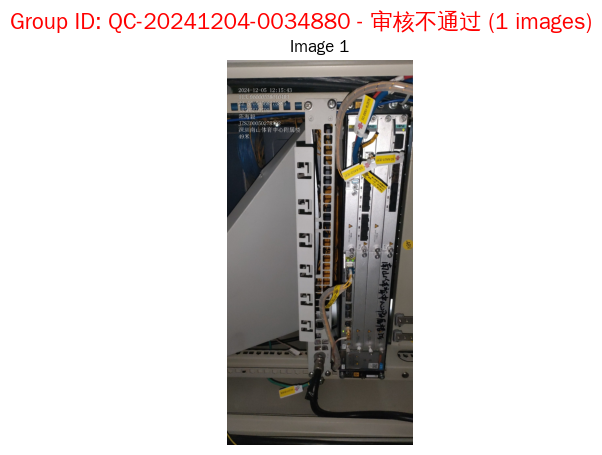


📊 STEP 3.2: Data Analysis
--------------------------------------------------------------------------------
Mode: Stage-A Only
Showing: Stage-A label and per-image summaries




Analysis complete!


In [8]:
# ============================================================================
# STEP 3: Visualize the ticket
# ============================================================================
print(f"\n{'=' * 80}")
print(f"Visualizing Group ID: {GROUP_ID}")
print(f"{'=' * 80}\n")

# Step 3.1: Display images (if available)
if images_by_subdir:
    print("\n📸 STEP 3.1: Review Images (Grouped by Submission Directory)")
    print("-" * 80)
    print("Note: Images are displayed separately for each submission directory.")
    print(
        "A group_id can have images in both '审核通过' and '审核不通过' directories.\n"
    )
    display_images_by_subdir(images_by_subdir, GROUP_ID)
else:
    print("\n📸 STEP 3.1: Images")
    print("-" * 80)
    print(f"⚠️  No images found for group_id: {GROUP_ID}")
    print(f"   Searched in: {GROUP_DATA_BASE}")
    print(f"   Subdirectories: {POSSIBLE_SUBDIRS}\n")

# Step 3.2: Display data comparison
print("\n📊 STEP 3.2: Data Analysis")
print("-" * 80)

if has_need_review:
    print("Mode: Full Analysis (Stage-A + Stage-B)")
    print("Showing: Stage-A summaries, Model verdict, reasoning, and comparison\n")
elif has_stage_a:
    print("Mode: Stage-A Only")
    print("Showing: Stage-A label and per-image summaries\n")
else:
    print("Mode: Images Only")
    print("No Stage-A or Stage-B data available\n")

display_comparison(need_review_entry, stage_a_entry, GROUP_ID)

print("\n" + "=" * 80)
print("Analysis complete!")
print("=" * 80)